In [1]:
import tensorflow as tf
from bayes_tec.bayes_opt.maximum_likelihood_tec import *
import numpy as np
float_type = tf.float64

def test_solve():
    
    import numpy as np
    from seaborn import jointplot
    import pylab as plt
    plt.style.use('ggplot')
    freqs = np.linspace(120e6,160e6,20)
    tec_conversion = -8.448e9/freqs
    true_tec = np.random.uniform(-0.2,0.2,size=10000)#np.array([0.004]*1000)
    noise_rads = np.random.uniform(0.05,0.8,size=10000)#np.array([0.3]*1000)# a lot of noise on almost flat TEC is hard
    true_phase = true_tec[...,None] * tec_conversion
    phase = true_phase + noise_rads[...,None]*np.random.normal(size=true_phase.shape)

    tec_min, phase_sigma = solve_ml_tec(phase,freqs)
    plt.scatter(true_tec,tec_min)
    plt.xlabel("True tec")
    plt.ylabel("Pred tec")
    plt.show()
   
    
    jointplot(true_tec,tec_min,kind='hex')
    plt.show()
    jointplot(true_tec,tec_min,kind='kde',alpha=0.6,marker='+',color='k')
    plt.show()
    
    plt.scatter(noise_rads, phase_sigma)
    plt.xlabel("Pred phase noise")
    plt.ylabel("True phase noise")
    plt.show()
    jointplot(noise_rads, phase_sigma,kind='hex')
    plt.show()
    jointplot(noise_rads, phase_sigma,kind='kde',alpha=0.6,marker='+',color='k')
    plt.show()

def diagnostics():
    
    import numpy as np
    import pylab as plt
    plt.style.use('ggplot')
    freqs = np.linspace(120e6,160e6,20)
    tec_conversion = -8.448e9/freqs
    true_tec = np.random.uniform(-0.3,0.3,size=1000)#np.array([0.004]*1000)
    noise_rads = np.array([0.3]*1000)# a lot of noise on almost flat TEC is hard
    true_phase = true_tec[...,None] * tec_conversion
    phase = true_phase + noise_rads[...,None]*np.random.normal(size=true_phase.shape)
    
    _tec = true_tec[0]
    
    with tf.Session(graph=tf.Graph()) as sess:
        t_pl = tf.placeholder(float_type)
        phase_pl = tf.placeholder(float_type)
        tec_conversion_pl = tf.placeholder(float_type)
        X_init, Y_init = init_population(phase_pl,tec_conversion_pl,N=5)
        Xcur, Ycur = X_init, Y_init
        X_,Y_,aq_,fmean_,fvar_ = [],[],[],[],[]
        for i in range(21):
            res = bayes_opt_iter(phase_pl, tec_conversion_pl, Xcur, Ycur, max_tec=0.4, t = t_pl)
            X_.append(res.X)
            Y_.append(res.Y)
            aq_.append(res.aq)
            fmean_.append(res.fmean)
            fvar_.append(res.fvar)
            Xcur = res.X
            Ycur = res.Y
        X, Y, aq, fmean, fvar = sess.run([X_, Y_, aq_, fmean_, fvar_], feed_dict={t_pl:1.,
                                                                         phase_pl:phase,
                                                                        tec_conversion_pl:tec_conversion})
        
        indices = (np.arange(Y[-1].shape[0],dtype=np.int64), np.argmin(Y[-1][:,:,0],axis=1), np.zeros(Y[-1].shape[0], dtype=np.int64))
        tec_min = X[-1][indices]
        plt.scatter(tec_min, true_tec)
        plt.xlabel("pred. tec")
        plt.ylabel("true tec")
        plt.title("Scatter of solutions")
        plt.show()

        plt.hist(indices[1],bins=20)
        plt.title("Where was fmin attained")
        plt.xlabel("iteration including random init pop")
        plt.show()

        scatter = []
        for j in range(Y[-1].shape[1]):
            indices = (np.arange(Y[-1].shape[0],dtype=np.int64), np.argmin(Y[-1][:,:j+1,0],axis=1), np.zeros(Y[-1].shape[0], dtype=np.int64))
            tec_j = X[-1][indices]
            scatter.append(np.percentile(np.abs(tec_j - true_tec),95))

        plt.plot(scatter)
        plt.title("95% conf interval of |true_tec - pred_tec|")
        plt.xlabel("iteration")
        plt.ylabel("mean delta tec")
        plt.show()


        tec_array = np.linspace(-0.4, 0.4, 100)
        for i, (x, y, a, f, v) in enumerate(zip(X, Y, aq, fmean, fvar)):
            y = y - y.mean(1,keepdims=True)
            y = y / (np.std(y,axis=1,keepdims=True) + 1e-6)
            
            
            plt.plot(tec_array, f[0,:], label=r'$\mathbb{E}[f]$')
            plt.fill_between(tec_array, f[0,:] - 2*np.sqrt(v[0,:]), f[0,:] + 2*np.sqrt(v[0,:]),alpha=0.5, label=r'$\pm 2\sigma_f$')
            a = a - np.min(a,axis=1,keepdims=True)
            a = 3*a/np.max(a,axis=1,keepdims=True)
            plt.plot(tec_array,a[0,:],label='norm. acquisition func.')
            plt.scatter(x[0, :-1, 0], y[0,:-1, 0],c='k',label='sampled points')
            plt.scatter(x[0, -1, 0], y[0,-1, 0],c='red',label='New sample point')
            plt.vlines(_tec,-2,2,label='global. min',linestyles='--')
            plt.xlabel("tec")
            plt.ylabel("normalized neg-log-likelihood")
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
            plt.title("Iteration {}".format(i))
            plt.show()
            

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


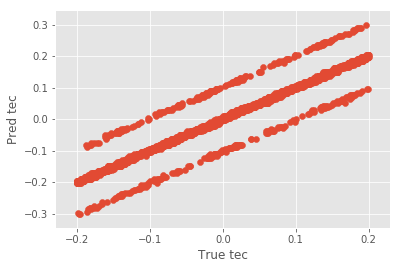

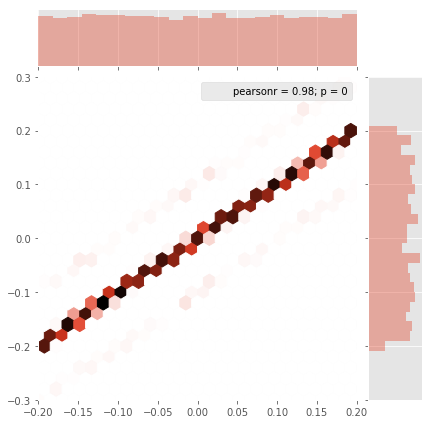

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'marker'
  s)


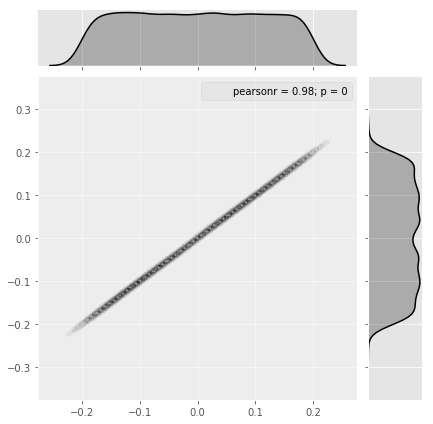

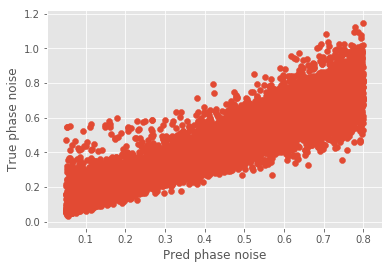

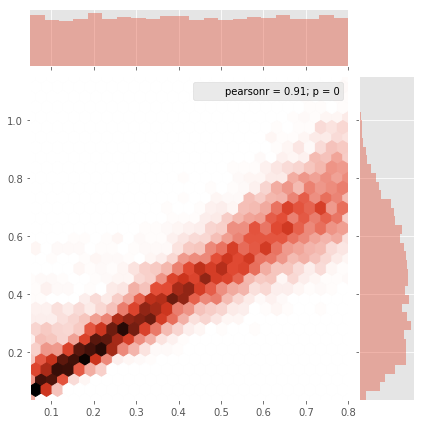

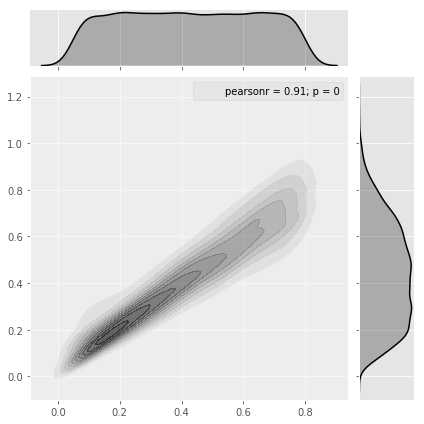

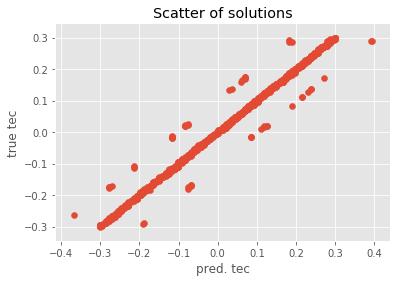

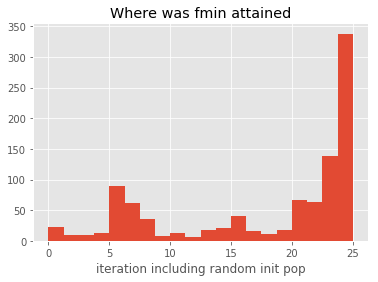

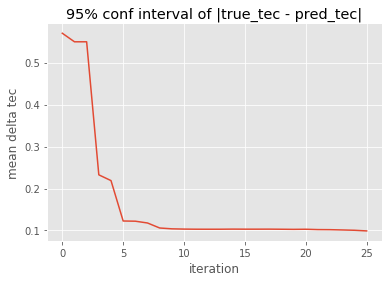

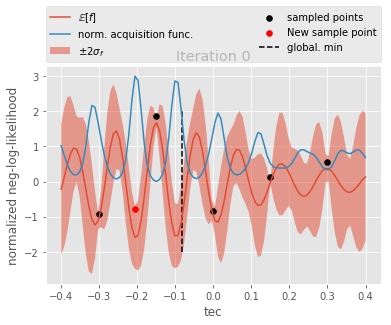

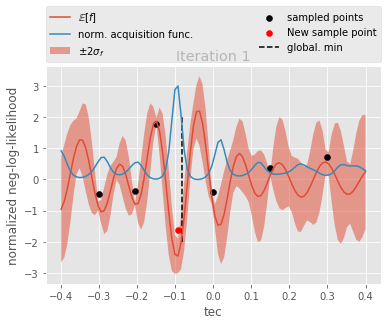

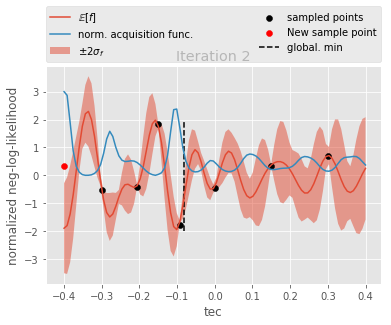

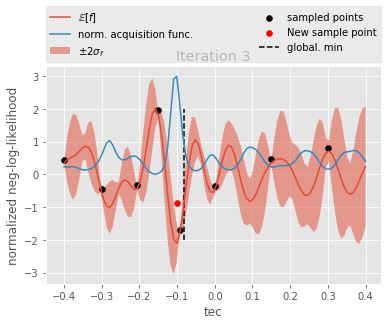

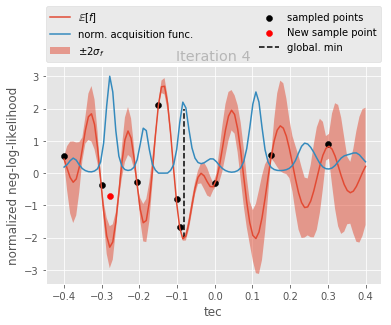

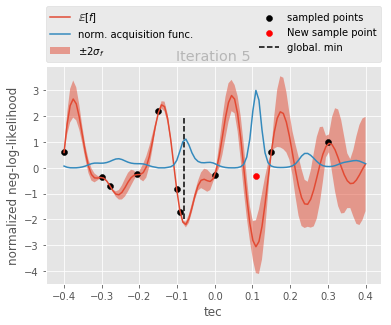

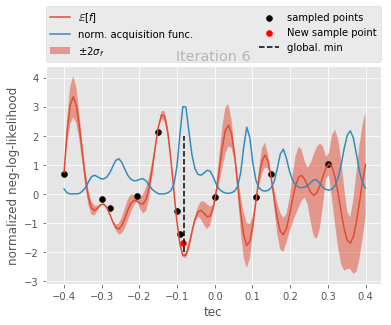

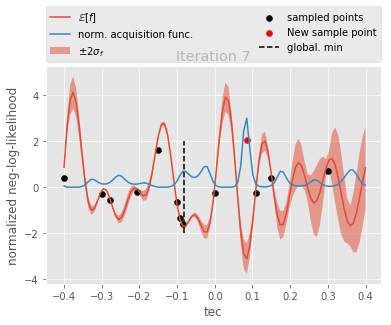

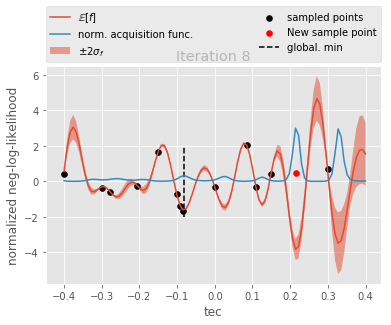

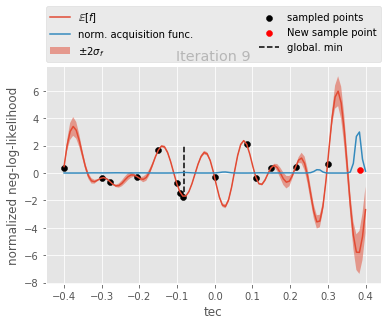

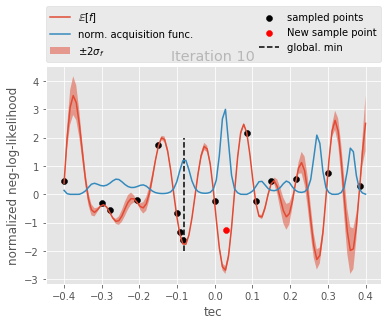

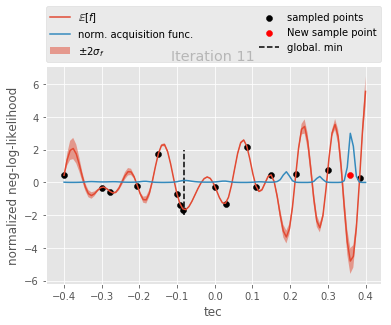

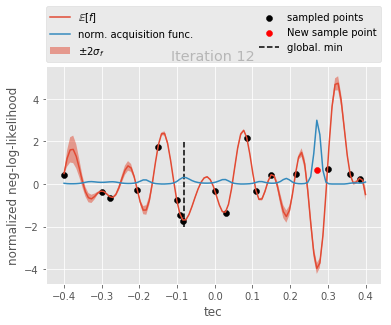

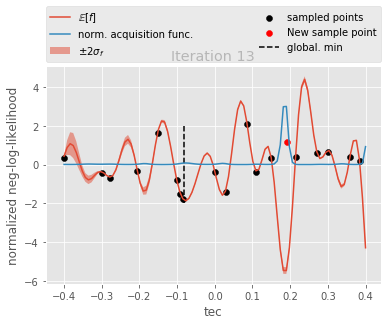

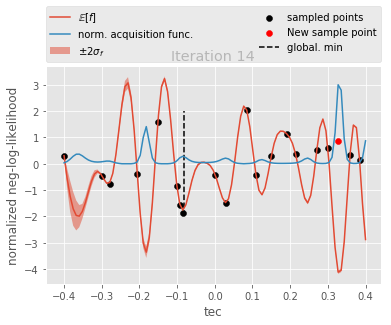

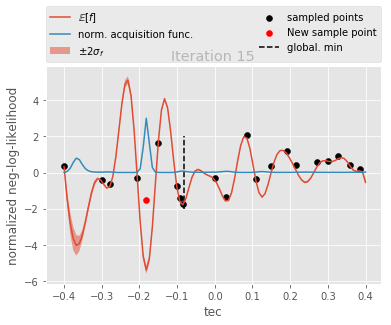

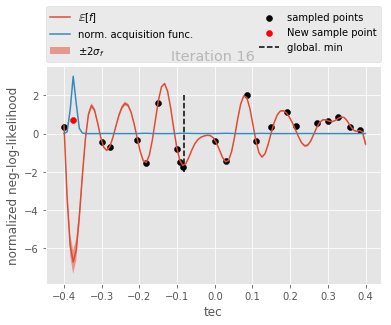

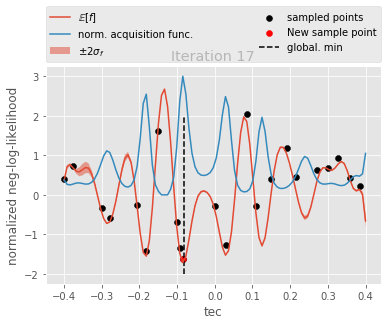

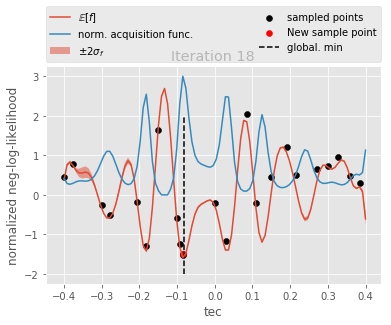

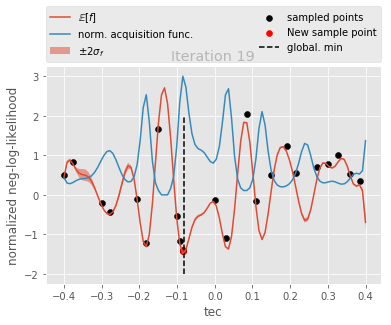

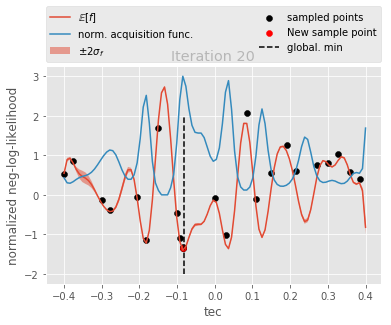

In [2]:
%matplotlib inline
test_solve()
diagnostics()

In [ ]:
from bayes_tec.datapack import DataPack
from timeit import default_timer
import h5py

with DataPack('../../scripts/data/killms_datapack.hdf5') as datapack:
    phase,axes = datapack.phase
    _, freqs = datapack.get_freqs(axes['freq'])
    Npol, Nd, Na, Nf, Nt = phase.shape
    phase = phase.transpose((0,1,2,4,3))
    phase = phase.reshape((-1, Nf))
    t0 = default_timer()
    tec_ml, sigma_ml = solve_ml_tec(phase, freqs, batch_size=int(1e6),max_tec=0.3, n_iter=21, t=1.,num_proposal=75, verbose=True)
    t1 = default_timer()
    print(t1-t0)
    tec_ml = tec_ml.reshape((Npol, Nd, Na, Nt))
    sigma_ml = sigma_ml.reshape((Npol, Nd, Na, Nt))
    with h5py.File('ml_results.hdf5') as f:
        f['tec'] = tec_ml
        f['sigma'] = sigma_ml
        
    

2018-09-15 14:06:33,482 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-15 14:06:33,488 Closing table.
2018-09-15 14:06:33,490 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-15 14:07:40,760 Starting batch 0
2018-09-15 14:18:08,909 Finished batch 0
2018-09-15 14:18:08,912 Starting batch 1000000
2018-09-15 14:28:20,971 Finished batch 1000000
2018-09-15 14:28:20,973 Starting batch 2000000
2018-09-15 14:38:22,319 Finished batch 2000000
2018-09-15 14:38:22,321 Starting batch 3000000
2018-09-15 14:48:22,554 Finished batch 3000000
2018-09-15 14:48:22,556 Starting batch 4000000
2018-09-15 14:58:18,499 Finished batch 4000000
2018-09-15 14:58:18,501 Starting batch 5000000
2018-09-15 15:08:12,458 Finished batch 5000000
2018-09-15 15:08:12,460 Starting batch 6000000
2018-09-15 15:18:07,319 Finished batch 6000000
2018-09-15 15:18:07,322 Starting batch 7000000
2018-09-15 15:28:03,596 Finished batch 7000000

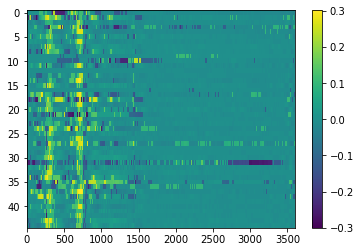

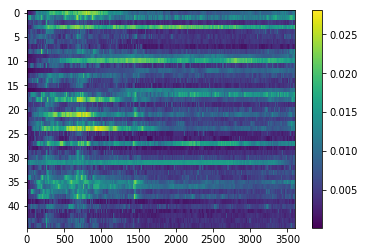

In [2]:
import h5py
with h5py.File('ml_results.hdf5') as f:
    tec_ml = f['tec'][0,:,51,:]
    sigma_ml = f['sigma'][0,:,51,:]
import pylab as plt
plt.imshow(tec_ml,aspect='auto')
plt.colorbar()
plt.show()
plt.imshow(sigma_ml*140e6/8.448e9,aspect='auto')
plt.colorbar()
plt.show()

In [3]:
import gpflow as gp
import numpy as np
with gp.defer_build():
    X = np.linspace(0,tec_ml.shape[1]*8.,tec_ml.shape[1])[:,None]
    Y = tec_ml.T[:,0:1]
    kern = gp.kernels.RBF(1)
    kern.lengthscales = 50.
    m = gp.models.GPR(X,Y,kern)
    m.compile()

In [4]:
gp.train.ScipyOptimizer().minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6868.391485
  Number of iterations: 19
  Number of functions evaluations: 28


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -6868.391485
  Number of iterations: 19
  Number of functions evaluations: 28


In [5]:
print(m)

                             class prior transform  trainable shape  \
GPR/kern/variance        Parameter  None       +ve       True    ()   
GPR/kern/lengthscales    Parameter  None       +ve       True    ()   
GPR/likelihood/variance  Parameter  None       +ve       True    ()   

                         fixed_shape                  value  
GPR/kern/variance               True   0.004046389875862616  
GPR/kern/lengthscales           True      51.43890867149286  
GPR/likelihood/variance         True  0.0008158251931517377  


In [6]:
from bayes_tec.datapack import DataPack

In [7]:
with DataPack('../../scripts/data/killms_datapack.hdf5') as datapack:
    weights,axes = datapack.weights_tec

In [1]:
from bayes_tec.plotting.plot_datapack import plot_data_vs_solution

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
plot_data_vs_solution('../../scripts/data/killms_datapack.hdf5','./1dsols',solution_solset='sol000',freq_sel=slice(12,13,1),pol_sel=slice(0,1,1))

2018-09-16 16:31:27,174 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-16 16:31:27,180 Closing table.
2018-09-16 16:31:27,181 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-16 16:31:29,846 Cannot select on axis freq, it doesn't exist. Ignored.
2018-09-16 16:31:30,019 Cannot select on axis freq, it doesn't exist. Ignored.


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/plotting/plot_datapack.py:423: RuntimeWarning: divide by zero encountered in true_divide
  std = np.where(weights > 0., 1./np.sqrt(weights), 0.)[:,:,:,None,:]*tec_conversion


2018-09-16 16:46:01,523 Closing table.
